# Objectives of the mission

The client is interested in understanding for one site in Catania, Italy:
1. The evolution of extreme precipitation frequency and severity due to climate change.
2. The assessment of the adequacy of their pipeline design for the mentioned site to withstand future precipitation conditions.

Two deliverables will be provided to complete the mission:

1. Recomputation of Intensity-Duration-Frequency (IDF) curves for future scenarios, with the aim to provide a % of increase of precipitation scenarios under future conditions. 
2. Recomputation of output tables of height clearance, section clearance and flow velocities based on the precipitation, to identify the additional sections that as of today are not at risk but will be at risk in the future.

# Methodology

The following methodology is applied to generate the two abovementioned deliverables:

1. **Definition of the area of interest**: Define a point to download the environmental data to perform the analysis. The pipeline system of the site of interest was designed using precipitation data at a rainfall station named *Catania a San Giuseppe La Rena* (UTM 4144073, 506089). Therefore, for coherence with the previous analysis, the analysis of the evolution of precipitation for different future climate and socieconomic scenarios will be performed at this same point.
2. **Download hourly ERA5 precipitation data (baseline scenario)**: Using the Copernicus Data Store API (via *cdsapi* Python package), the historical precipitation time-series for the period 1990-2023 from ERA5 is downloaded for this point.
3. **Generation of the Depth-Duration-Frequency curves (baseline scenario)**: Based on the orginal time-series of hourly precipitation, there are generated time-series of aggregated precipitation for 1, 2, 3, 6, 12 and 24 hours, using rolling windows. By means of the *pyextremes* Python package, the extreme value analysis of precipitation is performed. The Peak Over threshold (POT) method is applied. The threshold for extreme data selection has been selected for each event duration, based on visual validation.
4. **Download temperature data (baseline and future scenarios)**: Using the Copernicus Data Store API (via *cdsapi* Python package), monthly air temperature data for the area of interest is downloaded for an historical reference period (1984-2014, refered as baseline) and for future climate eras of 30 years, under different socioeconomic pathways (i.e. SSP24.5 and SSP58.5), for an ensemble of Global Climate Models (GCMs). The representative air temperature for the baseline, and time horizons 2030 and 2050 is computed as the mean of the monthly temperatures for the periods 1985-2014, 2015-2044 and 2035-2064 respectively, for the abovementioned socioeconomic pathways (SSPs do not apply for baseline scenario). Subsequently, the increase in air temperature for each model, socioeconomic pathway and time horizon with respect to the baseline is computed and, in turn, the representative increase for each scenario is computed as the median among all GCMs.
5. **Generation of the Depth-Duration-Frequency curves (future scenarios)**: By applying a function that integrates the Clausius Claperion principle, the DDF for future scenarios are computed. The function uses as input the baseline DDF curves and the temperature increases per scenario that had been computed in the steps described previously.
6. **Identification of the drainage system sections at risk (baseline scenario)**: The client had provided a report in which it was assessed the flood risk at multiple sections of the drainage system of the site, based on three conditions. Events of 50, 100 and 300-year return period were simulated to identify for which event frequencies each section is at risk. The mentioned three conditions of design are: 
    - **Freeboard of the section (*Franco della sezione*)**: The section is considered to be at risk for freeboards smaller than 50 cm.
    - **Degree of filling of the section (*Grado di riempimento della sezione*)**: The section is considered to be at risk if the degree of filling is larger than 66%.
    - **Flow velocity (*Velocita massime della corrente*)**: The section is considered to be at risk if the flow velocity is larger than 3 m/s.

Based on these three conditions, the sections at risk for the baseline scenario are identified. Besides, the relationship precipitation between precipitation depths and the three conditions is found.

7. **Identification of the drainage system sections at risk (future scenarios)**: Using the precipitation values for future scenarios for events of 50, 100 and 300-year return periods, and applying these values in the functions precipitation-conditions computed in the previous step, we can obtain the values of freeboards, degree of filling and flow velocities for each of the sections and future scenarios. By checking the described conditions, we can identify the sections of the drainage system that will be at risk for the selected future scenarios.

In [612]:
import os

# Project root
root = '/Users/aprida/Documents/Consulting/Private_sector/ST Microelectronics'

# Projects outputs root
root_output = f'{root}/output'
os.makedirs(root_output, exist_ok=True)

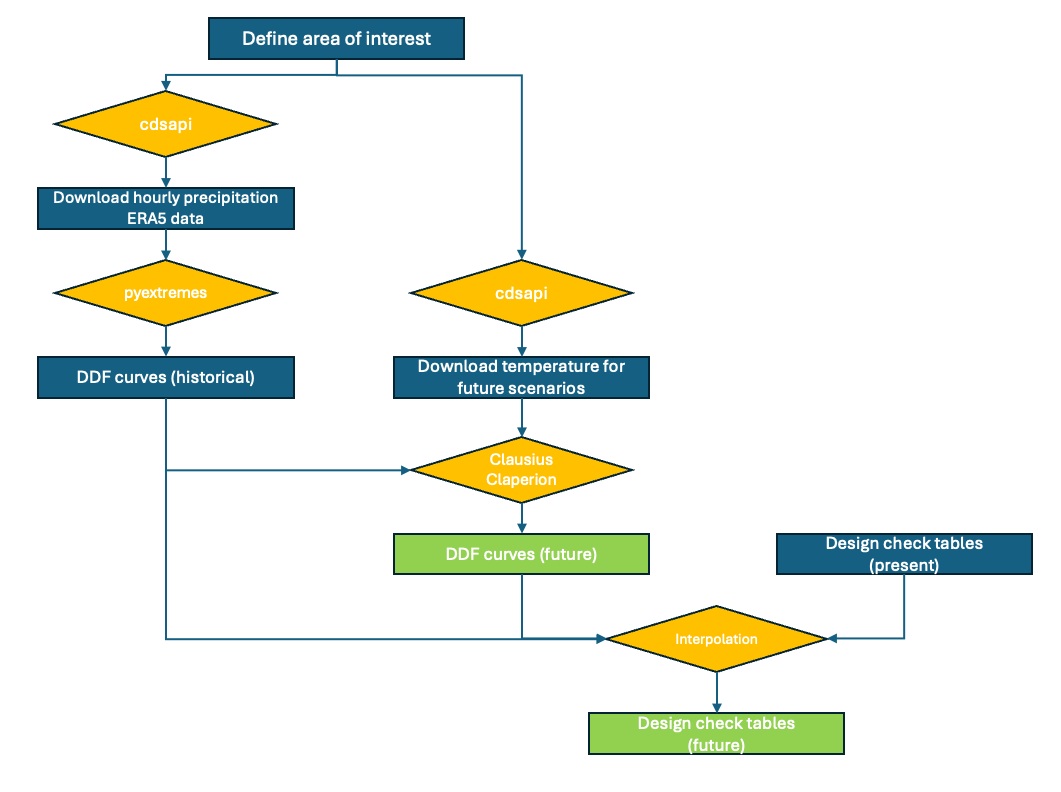

In [613]:
from IPython.display import Image, display

image_path = f'{root}/presentations/flow chart methodology.png'  # Replace with the actual image filename
display(Image(filename=image_path))

# Import packages

In [582]:
import cdsapi
import geopandas as gpd
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from shapely.geometry import box
import contextily as cx
import glob
from pyextremes import EVA, __version__
import numpy as np
from datetime import datetime
import zipfile
import matplotlib.pyplot as plt
import itertools
from openpyxl import load_workbook
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings("ignore")

# Define area of interest

In [584]:
# Set coordinates of ground climatologic station
x = [506089]
y = [4144073]

# Create geodataframe from coordinates
df_aoi= pd.DataFrame({'X': x, 'Y': y})
gdf_aoi = gpd.GeoDataFrame(data=df_aoi, geometry=gpd.points_from_xy(x, y), crs=32633)
gdf_aoi = gdf_aoi.to_crs(4326)
gdf_aoi.to_file(f'{root}/site_catania.geojson')
gdf_aoi

,X,Y,geometry
0,506089,4144073,POINT (15.06884 37.44348)


Text(79.17222222234157, 0.5, 'Latitude (degrees)')

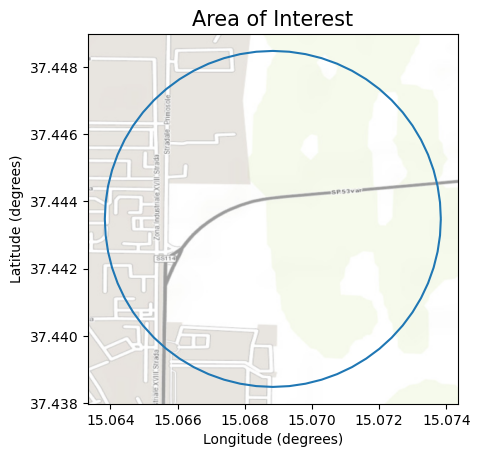

In [585]:
# Read vector of AOI
bb_aoi_shp = gpd.GeoDataFrame(geometry=[box(*gdf_aoi.total_bounds)]).buffer(0.005, join_style=2)
bb_aoi_bounds = bb_aoi_shp.bounds

# Plot

fig, ax = plt.subplots()
bb_aoi_shp.boundary.plot(ax=ax)
cx.add_basemap(ax=ax, crs=4326, source=cx.providers.Esri.WorldTopoMap, attribution=False)
ax.set_title(label="Area of Interest", fontsize=15)
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')

# DDF Curves (present)

## Download ERA5 precipitation data

ERA5 precipitation data can be extracted by calling the Climate Data Store API from Copernicus. A dedicated Python package exists for this end (cdsapi).

In [586]:
# Create folder to store Topography files

era5_path = os.path.join(root,'era5')

os.makedirs(era5_path, exist_ok=True)

# Define period of extraction

year_start = 1990
year_end = 2019
month_start = 1
month_end = 12
day_start = 1
day_end = 31

years = [str(element) for element in list(range(year_start, year_end+1))]
months = [str(element) for element in list(range(month_start, month_end+1))]
days = [str(element) for element in list(range(day_start, day_end+1))]

In [ ]:
# Use Climate Data Store API from Copernicus to download ERA5 precipitation data for the given bounding box and period

c = cdsapi.Client()

for year in years:

    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'format': 'netcdf',
            'variable': [
                'total_precipitation'
            ],
            'area': [bb_aoi_bounds['maxy'][0], bb_aoi_bounds['minx'][0], bb_aoi_bounds['miny'][0],bb_aoi_bounds['maxx'][0]
            ],
            'year': year,
            'month': months,
            'day': days,
            'time': ['00:00', '01:00', '02:00',
                     '03:00', '04:00', '05:00',
                     '06:00', '07:00', '08:00',
                     '09:00', '10:00', '11:00',
                     '12:00', '13:00', '14:00',
                     '15:00', '16:00', '17:00',
                     '18:00', '19:00', '20:00',
                     '21:00', '22:00', '23:00'
                    ]
        },
        os.path.join(era5_path, f'era5_catania.{year}_hourly.nc'))
    print(year)

In [587]:
filepaths = glob.glob('/Users/aprida/Documents/Consulting/Private_sector/ST Microelectronics/era5/*.nc')
filepaths = sorted(filepaths) # Rearrange precipitation yearly files in ascending order
ds_era5 = xr.open_mfdataset(filepaths, combine='nested', concat_dim='stat') # Concat yearly records into one file
ds_era5['tp'] = ds_era5['tp'] * 1000 # Convert from meters to milimiters
ds_era5 = ds_era5.rename_vars({'tp': 'precip'})

# Convert dataset to dataframe
df_precip = ds_era5.to_dataframe().reset_index()[['time', 'precip']]
df_precip.index = pd.to_datetime(df_precip.time)
df_precip.drop(columns='time', inplace=True)
df_precip['precip'] = df_precip.round(1) # Fill NA with 0
df_precip['precip'] = df_precip['precip'].fillna(0)

## Extreme value analysis of the precipitation

Time to plot:  0:00:24.835216


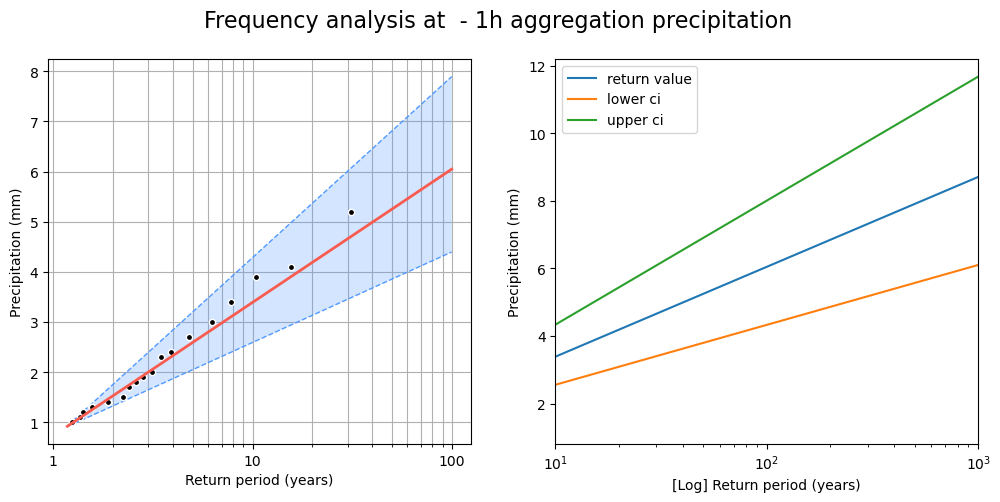

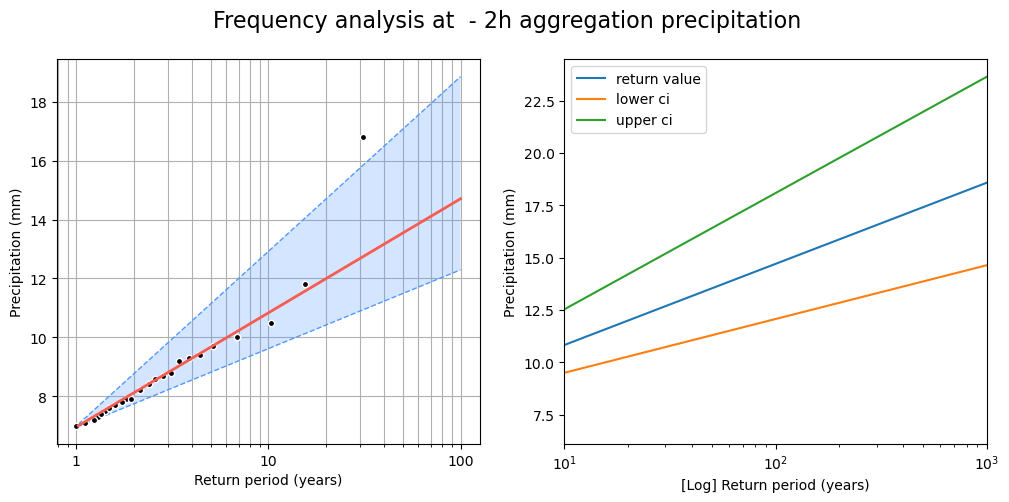

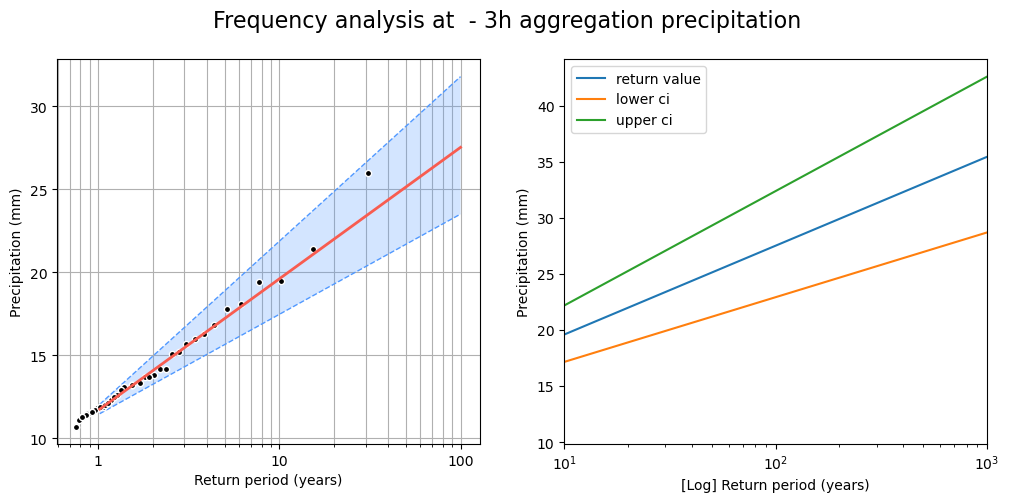

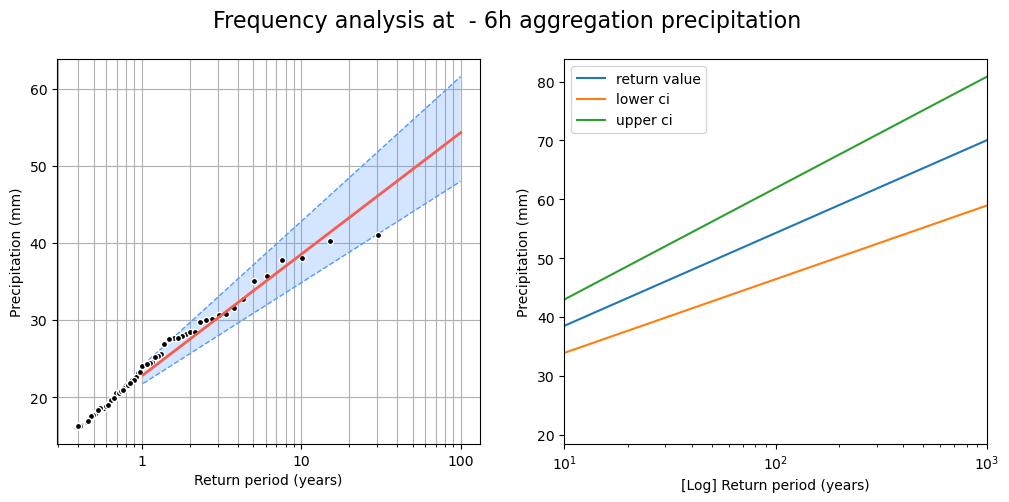

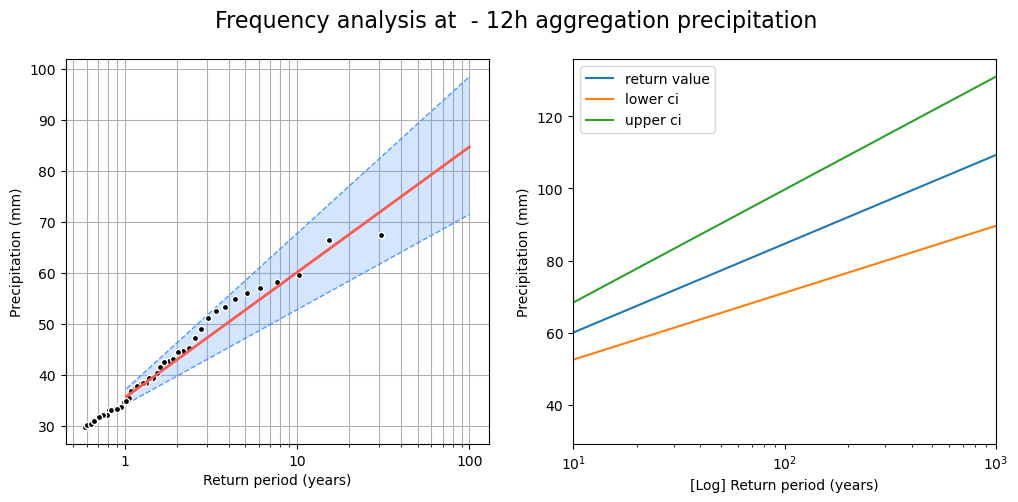

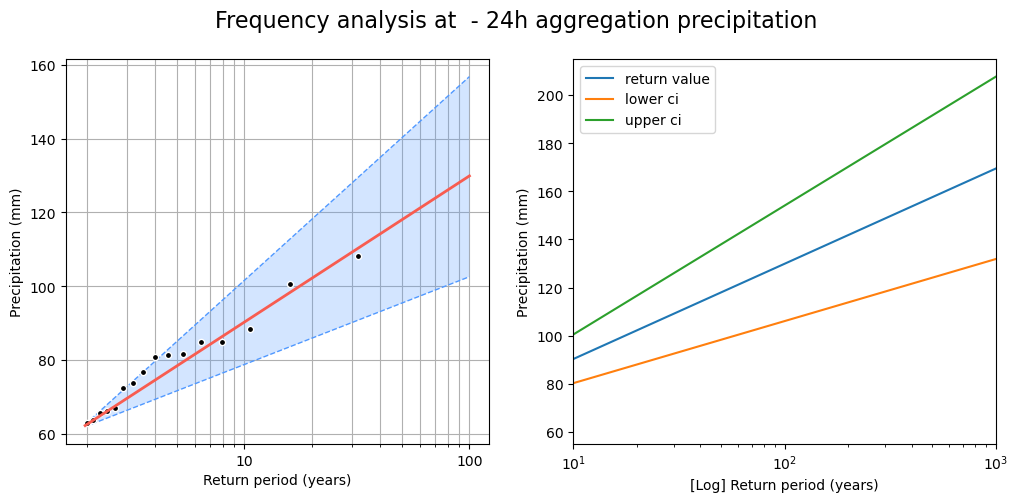

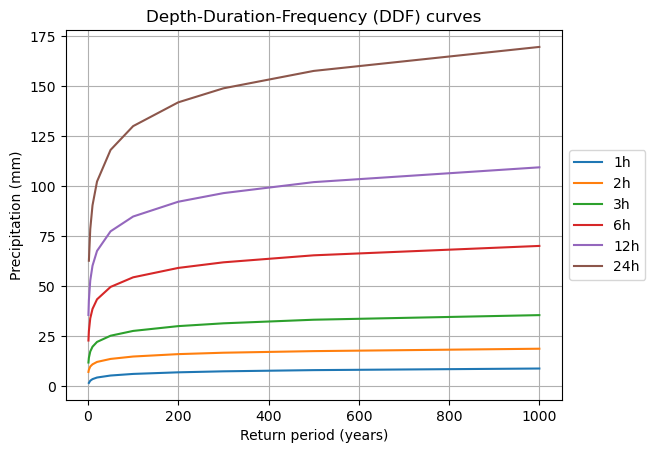

In [596]:
dt_start = datetime.now()

# Set aggregation times and thresholds for Peak Over Threshold analysis
df_precip['precip'] = df_precip['precip'].fillna(0)
agg_times = ['1h', '2h', '3h', '6h', '12h', '24h']
quants = [0.99, 0.999, 0.999, 0.998, 0.998, 0.999]

# Initialize return periods of interest
rp = [1, 2, 5, 10, 20, 50, 100, 200, 300, 500, 1000]
df_summary = pd.DataFrame(index=rp)
df_summary.index.name = 'return period'

for time, quant in zip(agg_times, quants):
    data = df_precip['precip'].rolling(window=time).sum()

    model = EVA(data=data)
    
    model.get_extremes(
        method="POT",
        extremes_type="high",
        threshold=data.quantile([quant]).values[0]
    )
    
    # Fit model
    model.fit_model()
    model

    fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12,5))
    
    model.plot_return_values(
        ax=ax1,
        return_period=np.logspace(0.01, 2, 100),
        return_period_size="365.2425D",
        alpha=0.95
    )
    ax1.set_xlabel('Return period (years)')
    ax1.set_ylabel('Precipitation (mm)')
    ax1.grid
    
    # model.plot_diagnostic(alpha=0.95)
    
    summary = model.get_summary(
        return_period=[1, 2, 5, 10, 20, 50, 100, 200, 300, 500, 1000],
        alpha=0.95,
        n_samples=1000,
    )

    df_summary[time] = summary['return value']
    
    summary.plot(ax=ax2)
    ax2.set_xlabel('[Log] Return period (years)')
    ax2.set_ylabel('Precipitation (mm)')
    ax2.set_xlim(10,1000)
    ax2.semilogx()
    ax2.grid

    fig.suptitle(f'Frequency analysis at  - {time} aggregation precipitation', fontsize=16)

# Plot the Depth-Duration-Frequency Curves (summary of all plots)

fig, ax = plt.subplots()

df_summary = round(df_summary, 1)
df_summary.plot(ax=ax)
ax.set_xlabel('Return period (years)')
ax.set_ylabel('Precipitation (mm)')
ax.set_title('Depth-Duration-Frequency (DDF) curves')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid()

print('Time to plot: ', datetime.now() - dt_start)

# DDF Curves (future)

The raw temperature data can be extracted using the Copernicus Data Store (CDS), which can be called from Python using the *cdsapi* package. Documentation is available in the following website: https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=form). In this case, GCM are read directly from API for demonstration, but also possible to read GCM downscaled temperature databases are available.

Eight specific GCMs have been selected for their peer reviewed performance in representing air temperature (i.e. reduced bias with respect to climatologic stations on the ground for the historical period) in the region of interest:
- BCC-CSM2-MR
- CESM2
- CNRM-CM6-1
- CNRM-ESM2-1
- GFDL-ESM4
- HadGEM3-GC31-LL
- KACE-1-0-G
- MRI-ESM2-0


Source: https://esd.copernicus.org/articles/14/457/2023/esd-14-457-2023.pdf


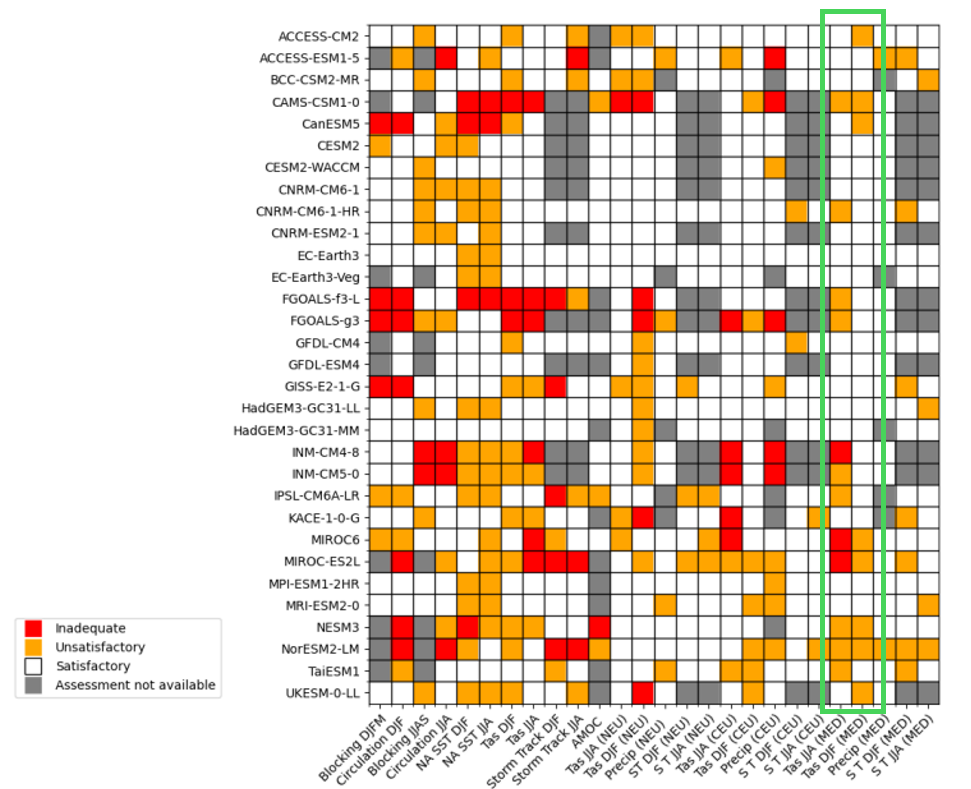

In [614]:
image_path = f'{root}/presentations/performant_gcms_in_mediterranean_region.png'  # Replace with the actual image filename
display(Image(filename=image_path))

## Download CMIP6 temperature data for baseline and future scenarios

Text(88.0472222222222, 0.5, 'Latitude (degrees)')

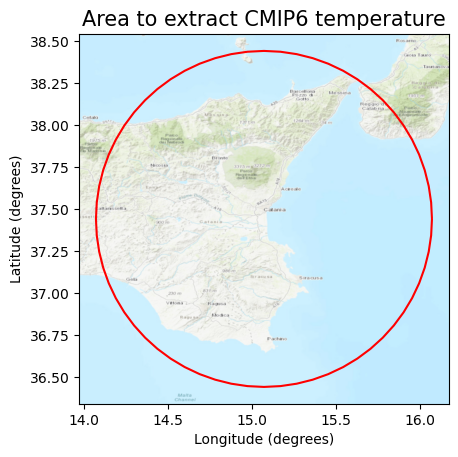

In [590]:
# Define bounding box to extract temperature data
bb_aoi_shp = gpd.GeoDataFrame(geometry=[box(*gdf_aoi.total_bounds)]).buffer(1, join_style=2)
bb_aoi_bounds = bb_aoi_shp.bounds

# Plot bounding box
fig, ax = plt.subplots()
bb_aoi_shp.boundary.plot(ax=ax, color='red')
cx.add_basemap(ax=ax, crs=4326, source=cx.providers.Esri.WorldTopoMap, attribution=False)
ax.set_title(label="Area to extract CMIP6 temperature", fontsize=15)
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')

In [ ]:
t_start = datetime.datetime.now()

# Create directory to store temperature files

temp_path = f'{root}/temp_cmip6'
os.makedirs(temp_path, exist_ok=True)

# Define experiments and model to consult

experiments = ['historical', 'ssp245', 'ssp585'] # ['ssp126', 'ssp245']
models = [
    "bcc_csm2_mr", "cesm2", "cnrm_cm6_1", "cnrm_esm2_1", "gfdl_esm4",
    "hadgem3_gc31_ll", "kace_1_0_g", "mri_esm2_0"
] # Global Climate Models (GCMs) to explore, based on paper that evaluates performance in Mediterranean Europe region

# Download historical data (baseline)

c = cdsapi.Client()

for j in models:

    if os.path.exists(os.path.join(temp_path, f'2005_baseline_{j}.zip')):

        pass

    else:
        
        try:
        
            c.retrieve(
                'projections-cmip6',
                {
                    'format': 'zip',
                    'temporal_resolution': 'monthly', # Possible to download daily data too
                    'experiment': 'historical',
                    'level': 'single_levels',
                    'variable': 'near_surface_air_temperature',
                    'model': f'{j}', # f'{j}'
                    'date': '1990-01-01/2019-12-31',
                    'area': [bb_aoi_bounds['maxy'][0], bb_aoi_bounds['minx'][0], bb_aoi_bounds['miny'][0],bb_aoi_bounds['maxx'][0]
                    ]
                },
                os.path.join(temp_path, f'2005_baseline_{j}.zip')
            )
    
        except:
    
            print(f'2005_baseline_{j}')
            pass

# Download data for future scenarios

for i in experiments[1:]:
    for j in models:
        
        if os.path.exists(os.path.join(temp_path, f'2030_{i}_{j}.zip')):
            
            pass

        else:
            
            try:
                
                c.retrieve(
                    'projections-cmip6',
                    {
                        'format': 'zip',
                        'temporal_resolution': 'monthly',
                        'experiment': f'{i}',
                        'level': 'single_levels',
                        'variable': 'near_surface_air_temperature',
                        'model': f'{j}',
                        'date': '2015-01-01/2044-12-31',
                        'area': [bb_aoi_bounds['maxy'][0], bb_aoi_bounds['minx'][0], bb_aoi_bounds['miny'][0],bb_aoi_bounds['maxx'][0]]
        
                    },
                    os.path.join(temp_path, f'2030_{i}_{j}.zip')
                )
                
            except:
                print(f'2030_{i}_{j}')
                pass

for i in experiments[1:]:
    for j in models:

        if os.path.exists(os.path.join(temp_path, f'2050_{i}_{j}.zip')):
            
            pass

        else:

            try:
            
                c.retrieve(
                    'projections-cmip6',
                    {
                        'format': 'zip',
                        'temporal_resolution': 'monthly',
                        'experiment': f'{i}',
                        'level': 'single_levels',
                        'variable': 'near_surface_air_temperature',
                        'model': f'{j}',
                        'date': '2035-01-01/2064-12-31',
                        'area': [bb_aoi_bounds['maxy'][0], bb_aoi_bounds['minx'][0], bb_aoi_bounds['miny'][0],bb_aoi_bounds['maxx'][0]]
        
                    },
                    os.path.join(temp_path, f'2050_{i}_{j}.zip')
                )

            except:

                print(f'2050_{i}_{j}')
                pass

print(datetime.datetime.now() - t_start)

In [468]:
# Extract files within zip files

files = glob.glob(f'{temp_path}/*.zip')

# Iterate over each file
for file in files:
    # Check if the file is a zip file
    if file.endswith('.zip'):
        # Construct the full path to the zip file
        zip_file_path = file
        
        # Extract the contents of the zip file into the same directory
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(temp_path)

cmip6_nc_rel = glob.glob(f'{temp_path}/tas*.nc')

# Read extracted .nc files per future scenario and GCM

def extract_and_rename_files(directory):
    # Get all zip files in the directory
    files = [file for file in os.listdir(directory) if file.endswith('.zip')]
    
    # Iterate over each zip file
    for file in files:
        # Construct the full path to the zip file
        zip_file_path = os.path.join(directory, file)
        
        # Extract the contents of the zip file into the same directory
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            # Extract each file in the zip archive
            for member in zip_ref.namelist():
                # Add the prefix to the extracted file's name
                new_name = file[:4] + '_' + member
                # Extract the file
                zip_ref.extract(member, directory)
                # Rename the extracted file with the new name
                os.rename(os.path.join(directory, member), os.path.join(directory, new_name))

# Example usage:
directory_path = temp_path
extract_and_rename_files(directory_path)

## Compute temperature increase for future climate scenarios

In [591]:
# Compute average yearly temperatures for future climate scenarios over different climate eras, and per Global Climate Model (GCM)
cmip6_nc_rel = glob.glob(f'{temp_path}/*tas*.nc')
df_all = pd.DataFrame()

for file in cmip6_nc_rel:

    ds = xr.open_dataset(file)
    exp = ds.attrs['experiment_id']
    mod = ds.attrs['source_id']
    th = file.split('/')[-1][:4]
    da = ds['tas']
    weights = np.cos(np.deg2rad(da.lat))
    weights.name = "weights"
    da_weighted = da.weighted(weights)
    da_agg = da_weighted.mean(['lat', 'lon'])
    da_yr = da_agg.groupby('time.year').mean()
    da_yr = da_yr - 273.15
    df_yr = da_yr.to_dataframe()[['tas']]
    df_yr['scenario'] = exp
    df_yr['model'] = mod
    df_yr['time_horizon'] = th

    df_all = pd.concat([df_all, df_yr], axis=0)

df_deltaT = df_all.pivot_table(values='tas', index = 'model', columns=['time_horizon', 'scenario'], aggfunc='mean')
print('\nAbsolute yearly average temperatures in future scenarios per GCM (in degrees Celsius).')
print(df_deltaT.round(2).to_markdown())

for column in df_deltaT.columns[1:]:
    df_deltaT[column] = df_deltaT[column] - df_deltaT[df_deltaT.columns[0]]

df_deltaT = df_deltaT.drop('2005', axis=1)
print('\n\nAbsolute increase in yearly average temperatures in future scenarios per GCM with respect to 2005 (in degrees Celsius).')
print(df_deltaT.round(2).to_markdown())

df_deltaT = pd.DataFrame(df_deltaT.median(), columns=['delta_t'])
print('\n\nAbsolute increase in yearly average temperatures in future scenarios with respect to 2005 (GCM median, in degrees Celsius).')
print(df_deltaT.round(2).to_markdown())


Absolute yearly average temperatures in future scenarios per GCM (in degrees Celsius).
| model           |   ('2005', 'historical') |   ('2030', 'ssp245') |   ('2030', 'ssp585') |   ('2050', 'ssp245') |   ('2050', 'ssp585') |
|:----------------|-------------------------:|---------------------:|---------------------:|---------------------:|---------------------:|
| BCC-CSM2-MR     |                    18.72 |                19.53 |                19.64 |                20.09 |                20.72 |
| CESM2           |                    19.11 |                19.91 |                20.34 |                20.68 |                21.32 |
| CNRM-CM6-1      |                    18.29 |                18.99 |                19.13 |                19.44 |                20.15 |
| CNRM-ESM2-1     |                    18.76 |                19.75 |                19.87 |                20.09 |                20.46 |
| GFDL-ESM4       |                    17.6  |                18.39 |         

## Compute future DDF curves


Precipitation depths (mm) for baseline and future scenarios with respect to the baseline:



1h    2h    3h    6h    12h    24h
th   ssp    return period                                     
2030 ssp245 5              2.8  10.3  18.3  35.9   56.0   83.3
            10             3.6  11.5  20.8  40.9   63.9   96.0
            20             4.5  12.8  23.4  46.0   71.7  108.6
            50             5.5  14.3  26.7  52.6   82.2  125.4
            100            6.4  15.6  29.2  57.7   90.0  138.1
            200            7.2  16.9  31.8  62.7   97.9  150.7
            300            7.8  17.6  33.3  65.7  102.5  158.2
            500            8.4  18.5  35.2  69.4  108.3  167.4
            1000           9.2  19.8  37.6  74.4  116.2  180.2
     ssp585 5              2.8  10.5  18.6  36.6   57.0   84.8
            10             3.7  11.7  21.2  41.7   65.0   97.7
            20             4.5  13.0  23.8  46.9   73.0  110.6
            50             5.6  14.6  27.2  53.6   83.6  127.7
            100            6.5  15.9  29.8  58.8   91.6  140.6
            200            7.4  17.2  32.4  63.8   99.7  153.4
            300            7.9  18.0  33.9  66.9  104.3  161.0
            500            8.5  18.8  35.8  70.7  110.3  170.4
            1000           9.4  20.1  38.3  75.7  118.3  183.4
2050 ssp245 5              2.8  10.6  18.9  37.0   57.8   85.9
            10             3.7  11.8  21.5  42.2   65.9   99.0
            20             4.6  13.2  24.1  47.5   74.0  112.0
            50             5.7  14.8  27.5  54.3   84.7  129.3
            100            6.6  16.1  30.1  59.5   92.8  142.4
            200            7.5  17.4  32.8  64.7  100.9  155.4
            300            8.0  18.2  34.3  67.7  105.7  163.1
            500            8.7  19.1  36.3  71.6  111.7  172.6
            1000           9.5  20.4  38.8  76.7  119.8  185.8
     ssp585 5              3.0  11.1  19.7  38.6   60.2   89.6
            10             3.9  12.3  22.4  44.0   68.7  103.2
            20             4.8  13.7  25.2  49.5   77.2  116.8
            50             5.9  15.4  28.7  56.6   88.4  134.9
            100            6.9  16.8  31.4  62.1   96.8  148.5
            200            7.8  18.2  34.2  67.5  105.3  162.1
            300            8.3  19.0  35.8  70.7  110.2  170.1
            500            9.0  19.9  37.8  74.7  116.5  180.1
            1000           9.9  21.3  40.5  80.0  125.0  193.8

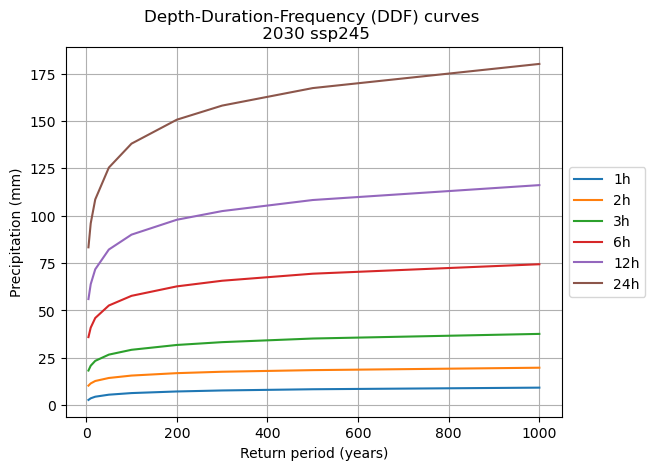

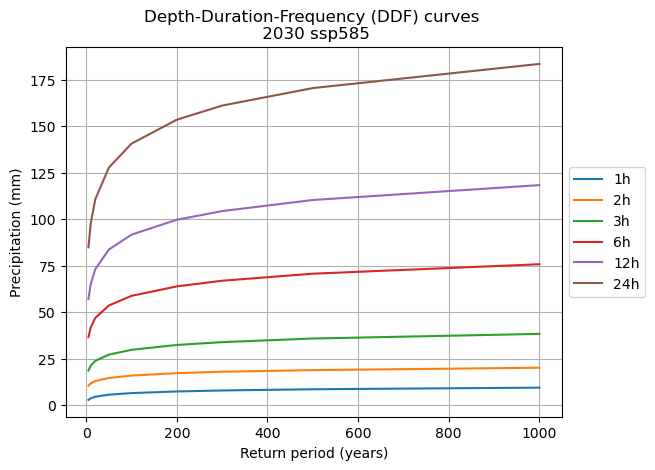

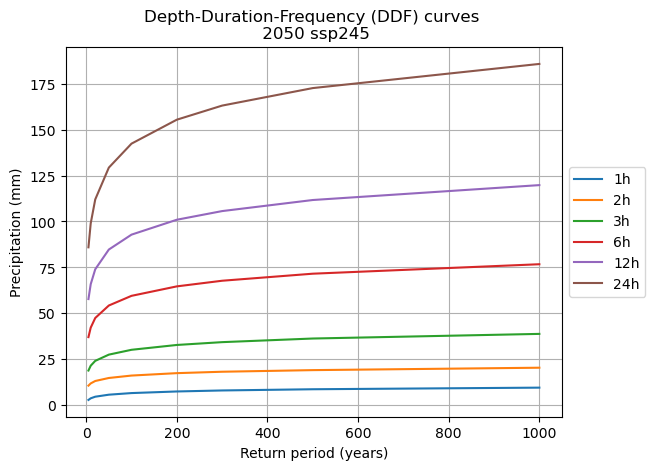

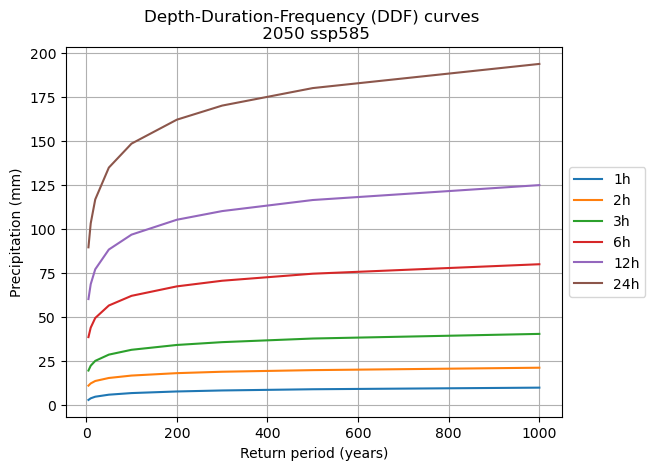

In [610]:
# Generate design hyetographs for different return periods and flood durations
df_summary_cc_all = pd.DataFrame()

for sc in df_deltaT.index:

    # Compute future precipitation depths per RP and climate scenario
    # Source: https://climatedata.ca/resource/idf-data-and-climate-change/
    
    df_summary_cc = df_summary[df_summary.index >=5] * 1.07 ** df_deltaT.loc[sc, 'delta_t']

    # Plot the Depth-Duration-Frequency Curves (summary of all plots)
    
    fig, ax = plt.subplots()
    
    df_summary_cc.plot(ax=ax)
    ax.set_xlabel('Return period (years)')
    ax.set_ylabel('Precipitation (mm)')
    ax.set_title(f'Depth-Duration-Frequency (DDF) curves \n {sc[0]} {sc[1]}')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid()
    
    df_summary_cc = df_summary_cc.reset_index(names='return period')
    df_summary_cc['th'] = sc[0]
    df_summary_cc['ssp'] = sc[1]
    df_summary_cc.set_index(['th', 'ssp', 'return period'], inplace=True)
    df_summary_cc_all = pd.concat([df_summary_cc_all, df_summary_cc])

df_summary_cc_all = round(df_summary_cc_all, 1)
df_summary_bis = df_summary[df_summary.index >=5].reset_index()
df_summary_bis['th'] = 'baseline'
df_summary_bis['ssp'] = 'baseline'
df_summary_bis.set_index(['th', 'ssp', 'return period'], inplace=True)
df_summary_cc_all_bis = pd.concat([df_summary_bis, df_summary_cc_all])
df_summary_cc_all_bis.to_excel(f'{root_output}/ddfcurves_precip_baseline_future.xlsx')

print('\nPrecipitation depths (mm) for baseline and future scenarios with respect to the baseline:\n')
df_summary_cc_all

## Compute increase in precipitation for future scenarios

In [605]:
import pandas as pd

# Create an empty DataFrame to store the results
df_diff = pd.DataFrame(columns=df_summary_cc_all.columns, index=df_summary_cc_all.index)

# Loop through each block in the second DataFrame
for i in range(0, df_summary_cc_all.shape[0], df_summary_bis.shape[0]):
    # Select the current block
    block = df_summary_cc_all.iloc[i:i + df_summary_bis.shape[0]]
    # Compute the difference with df_summary_bis
    diff = block.values - df_summary_bis.values
    # Store the result
    df_diff.iloc[i:i + df_summary_bis.shape[0]] = diff

# Rename the columns to indicate the increase in mm
df_diff.columns = [f'{col}_mm_increase' for col in df_diff.columns]

# Calculate the percentage increase
df_pct_increase = pd.DataFrame(columns=df_summary_cc_all.columns, index=df_summary_cc_all.index)

for i in range(0, df_summary_cc_all.shape[0], df_summary_bis.shape[0]):
    # Select the current block
    block = df_summary_cc_all.iloc[i:i + df_summary_bis.shape[0]]
    # Compute the percentage increase
    pct_increase = (block.values - df_summary_bis.values) / df_summary_bis.values * 100
    # Store the result
    df_pct_increase.iloc[i:i + df_summary_bis.shape[0]] = pct_increase.round(1)

# Rename the columns for percentage increase
df_pct_increase.columns = [f'{col}_pct_increase' for col in df_pct_increase.columns]

# Concatenate the difference and percentage increase DataFrames
df_result = pd.concat([df_diff, df_pct_increase], axis=1)
df_result.to_excel(f'{root_output}/increase_precip_mm_perc_futurescenarios.xlsx')

# Print the subset of percentage increase DataFrame for specific third index levels
print('\nPercentage increase in precipitation depths (mm) for future scenarios with respect to the baseline:\n')
df_pct_increase.loc[pd.IndexSlice[:, :, [50, 100, 300]], :].sort_index()



Percentage increase in precipitation depths (mm) for future scenarios with respect to the baseline:



1h_pct_increase 2h_pct_increase  \
th       ssp      return period                                   
2030     ssp245   50                        5.8             5.9   
                  100                       6.7             6.1   
                  300                       6.8             6.0   
         ssp585   50                        7.7             8.1   
                  100                       8.3             8.2   
                  300                       8.2             8.4   
2050     ssp245   50                        9.6             9.6   
                  100                      10.0             9.5   
                  300                       9.6             9.6   
         ssp585   50                       13.5            14.1   
                  100                      15.0            14.3   
                  300                      13.7            14.5   
baseline baseline 50                        0.0             0.0   
                  100                       0.0             0.0   
                  300                       0.0             0.0   

                                3h_pct_increase 6h_pct_increase  \
th       ssp      return period                                   
2030     ssp245   50                        6.4             6.3   
                  100                       6.2             6.3   
                  300                       6.4             6.3   
         ssp585   50                        8.4             8.3   
                  100                       8.4             8.3   
                  300                       8.3             8.3   
2050     ssp245   50                        9.6             9.7   
                  100                       9.5             9.6   
                  300                       9.6             9.5   
         ssp585   50                       14.3            14.3   
                  100                      14.2            14.4   
                  300                      14.4            14.4   
baseline baseline 50                        0.0             0.0   
                  100                       0.0             0.0   
                  300                       0.0             0.0   

                                12h_pct_increase 24h_pct_increase  
th       ssp      return period                                    
2030     ssp245   50                         6.3              6.3  
                  100                        6.3              6.3  
                  300                        6.3              6.3  
         ssp585   50                         8.2              8.2  
                  100                        8.1              8.2  
                  300                        8.2              8.2  
2050     ssp245   50                         9.6              9.6  
                  100                        9.6              9.6  
                  300                        9.6              9.6  
         ssp585   50                        14.4             14.3  
                  100                       14.3             14.3  
                  300                       14.3             14.3  
baseline baseline 50                         0.0              0.0  
                  100                        0.0              0.0  
                  300                        0.0              0.0

# Assessment of the pipeline system design

In [608]:
# Functions for visualization

# Freeboard (in meters)
def freeboard_viz(val):
    color = ''
    if val <= 0.5:
        color = 'red'
    return 'background-color: %s' % color

# Section filling (in %)
def section_viz(val):
    color = ''
    if val >= 0.66:
        color = 'red'
    return 'background-color: %s' % color

# Flow velocity (in meters per second)
def velocity_viz(val):
    color = ''
    if val >= 3:
        color = 'red'
    return 'background-color: %s' % color

In [611]:
# Conditons considered

tables_path = '/Users/aprida/Documents/Consulting/Private_sector/ST Microelectronics/tables_conditions_input.xlsx'

# Load the Excel file
workbook = load_workbook(tables_path)
sheet_names = workbook.sheetnames # Each condition table is saved in one sheet of the original Excel file

print(f"The conditions checked for each section and scenario are:\n\n{pd.DataFrame(sheet_names, columns=['condition']).to_markdown()}\n\n")

# Scenarios considered

# Extract unique values for 'th' and 'ssp'
th_values = df_summary_cc_all.index.get_level_values('th').unique()
ssp_values = df_summary_cc_all.index.get_level_values('ssp').unique()

# Generate all combinations of 'th' and 'ssp'
scenarios = list(itertools.product(th_values, ssp_values))
print(f"The future scenarios considered are:\n\n{pd.DataFrame(scenarios, columns=['time horizon', 'ssp']).to_markdown()}\n\n")

# Computation of the condition tables under future scenarios

for sheet_name in sheet_names:

    df_table = pd.read_excel(tables_path, sheet_name=sheet_name)
    
    t = '1h' # Design duration of pluvial events
    rp = [50, 100, 300] # Selected Return Periods as provided in the technical report
    df_table_future = pd.DataFrame()
    
    for sc in scenarios:
    
        th = sc[0] # Time horizon (2030, 2050)
        ssp = sc[1] # Socioeconomic Pathway (SSP)
        df_table_future_tmp_bis = pd.DataFrame()
    
        for structure in df_table['Structura'].unique():
        
            df = df_table[df_table['Structura']==structure]
            df.rename(columns={'Tr': 'return period'}, inplace=True)
            df.set_index('return period', inplace=True)
            df = df.drop(columns='Structura')
            
            precip_future = df_summary_cc_all.loc[(th, ssp, rp), t].values
            df_table_future_tmp = pd.DataFrame()
            
            for section in df.columns:
                df_tmp = pd.merge(df_summary.loc[rp][[t]], 
                                  df[[section]], 
                                  on='return period')
            
                # Example usage
                x = df_tmp[t]
                y = df_tmp[section]
                
                # Create interpolation function
                f = interp1d(x, y, fill_value="extrapolate")
                
                # Interpolated/extrapolated value
            
                df_table_future_tmp[f'{section}'] =  f(precip_future)
                
            df_table_future_tmp['return period'] = rp
            df_table_future_tmp['structure'] = structure
            df_table_future_tmp_bis = pd.concat([df_table_future_tmp_bis, df_table_future_tmp])
        
        df_table_future_tmp_bis['th'] = th
        df_table_future_tmp_bis['ssp'] = ssp
        df_table_future = pd.concat([df_table_future, df_table_future_tmp_bis])
    
    df_table_future.set_index(['th', 'ssp', 'structure', 'return period'], inplace=True)
    df_table['th'] = 'baseline'
    df_table['ssp'] = 'baseline'
    df_table.rename(columns={'Structura': 'structure', 'Tr': 'return period'}, inplace=True)
    df_table.set_index(['th', 'ssp', 'structure', 'return period'], inplace=True)
    df_table_future = pd.concat([df_table, df_table_future])
    df_table_future = round(df_table_future, 3)
    df_table_future.to_excel(f'{root_output}/section_risk_values_{sheet_name}.xlsx')

    df_table_future_stack = pd.DataFrame(df_table_future.stack()).reset_index().rename(columns={'level_4': 'section', 0: sheet_name})

    if sheet_name == 'Franco sezione (m)':
        styled_df = df_table_future.style.applymap(freeboard_viz)
        df_table_future_stack['condition'] = np.where(df_table_future_stack[sheet_name] < 0.5, 1, 0)

    elif sheet_name == 'Riempimento sezione (%)':
        styled_df = df_table_future.style.applymap(section_viz)
        df_table_future_stack['condition'] = np.where(df_table_future_stack[sheet_name] > 0.66, 1, 0)


    elif sheet_name == 'Velocita massime (m.s)':
        styled_df = df_table_future.style.applymap(velocity_viz)
        df_table_future_stack['condition'] = np.where(df_table_future_stack[sheet_name] > 3, 1, 0)
    
    styled_df = styled_df.format("{:.3f}")
    styled_df.set_table_styles([
        {'selector': 'table', 'props': [('border', 'solid 1px')]},
        {'selector': 'th', 'props': [('border', 'solid 1px')]},
        {'selector': 'td', 'props': [('border', 'solid 1px')]},
    ])
    
    print(f"{sheet_name}\n")
    
    display(styled_df)
    df_summary_sections = df_table_future_stack.pivot_table(index=['th', 'ssp'], columns=['structure', 'return period'], values='condition', aggfunc='sum')
    df_summary_sections = df_summary_sections.sort_index(axis=1)
    df_summary_sections.to_excel(f'{root_output}/sections_risk_counts_{sheet_name}.xlsx')
    df_summary_sections = df_summary_sections.style.set_table_styles([
        {'selector': 'table', 'props': [('border', 'solid 1px')]},
        {'selector': 'th', 'props': [('border', 'solid 1px')]},
        {'selector': 'td', 'props': [('border', 'solid 1px')]}
    ])
    
    print(f'\nSections at risk per future scenario (as per {sheet_name}):\n')
    display(df_summary_sections)
    print('\n\n')


The conditions checked for each section and scenario are:

|    | condition               |
|---:|:------------------------|
|  0 | Franco sezione (m)      |
|  1 | Riempimento sezione (%) |
|  2 | Velocita massime (m.s)  |


The future scenarios considered are:

|    |   time horizon | ssp    |
|---:|---------------:|:-------|
|  0 |           2030 | ssp245 |
|  1 |           2030 | ssp585 |
|  2 |           2050 | ssp245 |
|  3 |           2050 | ssp585 |


Franco sezione (m)




Sections at risk per future scenario (as per Franco sezione (m)):






Riempimento sezione (%)




Sections at risk per future scenario (as per Riempimento sezione (%)):






Velocita massime (m.s)




Sections at risk per future scenario (as per Velocita massime (m.s)):



# Conclusions

1. The increase of precipitation for design scenarios (50, 100, 300-year return period precipitation events of 1h duration) for future scenarios (time horizons 2030 and 2050, and socioeconomic pathways SSP24.5 and SSP58.5) has been computed, and the adequacy of the drainage system design for a list of preselected sections under the mentioned future scenarios has been checked.
2. Precipitation for design scenarios (50, 100, 300-year return periods of precipitation events of 1h duration) is expected to increase between 5.8% (SSP24.5) and 8.3% (SSP58.5) in 2030, and between 9.6% (SSP24.5) and 15.0% (SSP58.5) in 2050.
3. The increase on the number of sections of the drainage system at risk is mainly driven by the reduction of section freeboard (*Franco sezione (m)*) and the degree of filling of the sections (*Riempimiento sezione (%)*). The main points of attention are (it is recalled that 10 sections are checked for each of the two conditions mentioned):

    - __Section freeboard (*Franco sezione (m)*)__: The structural scenario *Ante tura 100* remains the most critical in terms of number of sections at risk. It sees an increase from 6 to 9 sections at risk for RP50, already in 2030 SSP24.5 future scenario. The structural scenario *Post tura 100* follows up, with an increase from 4 to 7 sections at risk for RP50, in 2050 SSP58.5 future scenario.
    - __Degree of filling of the sections (*Riempimiento sezione (%)*)__: Once again, the structural scenario *Ante tura 100* remains the most critical in terms of number of sections at risk. It sees an increase from 8 to 9 sections at risk for RP50, in 2050 SSP58.5 future scenario. The structural scenario *Post tura 100* follows up in terms of risk, however the number of sections at risk remains stable at 8 sections by 2050 SSP58.5 future scenario.
  
The rest of the structural scenarios are not at risk for RP50 precipitation scenario under present and future conditions analysed.